In [1]:
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from helper import CSV_DIR, SCOPE_DIR, FIG_DIR, PREFER_ORDER, COLOR_MAP  # noqa: E402

# –– Nature-ready styling
mpl.rcParams.update({
    # font
    'font.family': 'serif',
    'font.serif': ['Times New Roman', 'Times'],
    'mathtext.fontset': 'stix',
    # axes
    'axes.linewidth': 1.0,
    'axes.labelsize': 14,
    'axes.titlesize': 14,
    # ticks
    'xtick.major.size': 4,
    'ytick.major.size': 4,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    # legend
    'legend.fontsize': 14,
    'legend.title_fontsize': 14,
    # figure
    'figure.dpi': 300,
})
sns.set_style("whitegrid")  # subtle grid

In [2]:

# ──────────────────────────────────────────────────────────────
#                        ── existing helpers ──
# ──────────────────────────────────────────────────────────────
def list_agents(scope: bool = False,
                csv_dir: Path = CSV_DIR,
                scope_dir: Path = SCOPE_DIR) -> list[str]:
    """Return agent names that have metadata CSVs on disk."""
    if scope:
        return [d.name for d in scope_dir.iterdir()
                if (d / "repo_metadata.csv").exists()]
    agents: list[str] = []
    for fp in csv_dir.glob("*_repo_metadata.csv"):
        if "popular" in fp.stem:
            continue
        agents.append(fp.stem.replace("_repo_metadata", ""))
    return sorted(set(agents))


def load_repo_meta(agent: str,
                   scope: bool = False,
                   csv_dir: Path = CSV_DIR,
                   scope_dir: Path = SCOPE_DIR) -> pd.DataFrame:
    """Load the repository-level metadata CSV for one agent."""
    if scope:
        fp = scope_dir / agent / "repo_metadata.csv"
        scoped_prs_fp = scope_dir / agent / "prs.csv"
        if not fp.exists():
            alt = scope_dir / agent / "repo_metadata_head.csv"
            if alt.exists():
                fp = alt
    else:
        fp = csv_dir / f"{agent}_repo_metadata.csv"
        scoped_prs_fp = csv_dir / f"{agent}_prs.csv"
        if not fp.exists():
            alt = csv_dir / f"{agent}_repo_metadata_head.csv"
            if alt.exists():
                fp = alt
    if not fp.exists():
        raise FileNotFoundError(fp)
    repo_df = pd.read_csv(fp)
    pr_df = pd.read_csv(scoped_prs_fp)
    mask = repo_df['url'].isin(pr_df['repo_url'])
    return repo_df[mask]


def language_counts(agent: str,
                    scope: bool = False,
                    csv_dir: Path = CSV_DIR,
                    scope_dir: Path = SCOPE_DIR) -> pd.DataFrame:
    """Return repo-counts per language for a single agent."""
    df = load_repo_meta(agent, scope, csv_dir, scope_dir)
    counts = df["language"].value_counts(dropna=False).reset_index()
    counts.columns = ["language", "count"]
    return counts


def plot_language_usage(counts: pd.DataFrame,
                        agent: str,
                        scope: bool = False) -> None:
    """Bar-plot language frequencies for one agent."""
    if counts.empty:
        print(f"No language data for {agent}")
        return
    plt.figure(figsize=(6, 4))
    sns.barplot(x="language", y="count", data=counts, color="tab:blue")
    plt.xlabel("Language")
    plt.ylabel("Repository Count")
    title = f"{agent} repo languages" + (" (scope)" if scope else "")
    plt.title(title)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    FIG_DIR.mkdir(exist_ok=True, parents=True)
    suffix = "_scope" if scope else ""
    out = FIG_DIR / f"{agent}_languages{suffix}.png"
    plt.savefig(out)
    plt.close()
    print("Wrote", out)


def process_agent(agent: str,
                  scope: bool = False,
                  csv_dir: Path = CSV_DIR,
                  scope_dir: Path = SCOPE_DIR) -> None:
    """Create per-agent CSV and bar-plot."""
    try:
        counts = language_counts(agent, scope, csv_dir, scope_dir)
    except FileNotFoundError as e:
        print(e)
        return

    out_dir = (scope_dir / agent) if scope else csv_dir
    out_dir.mkdir(parents=True, exist_ok=True)
    out_fp = out_dir / ("languages.csv" if scope else f"{agent}_languages.csv")
    counts.to_csv(out_fp, index=False)
    print("Wrote", out_fp)
    plot_language_usage(counts, agent, scope)


# ──────────────────────────────────────────────────────────────
#                       ── SUMMARY helpers ──
# ──────────────────────────────────────────────────────────────
TOP_N = 10  # keep this many languages in the table

def _collect_stats(agents: list[str], scope: bool):
    """
    Return:
        count_df       : rows=agent, cols=language (raw counts)
        pct_df         : rows=agent, cols=language (% share)
        dedup_totals   : Series indexed by language (unique repo counts across all agents)
    """
    count_frames = []
    all_repos = []

    for agent in agents:
        df = load_repo_meta(agent, scope)[["url", "language"]]
        df = df.drop_duplicates(subset="url")
        df["agent"] = agent
        all_repos.append(df)
        print(f"Processing {agent} with {len(df)} repositories with languages: {df['language'].isna().sum()} missing")

        counts = df["language"].value_counts(dropna=False)
        count_frames.append(counts.rename(agent))

    count_df = pd.concat(count_frames, axis=1).T.fillna(0).astype(int)
    pct_df = (count_df.T / count_df.sum(axis=1)).T * 100
    pct_df = pct_df.round(1)

    combined_df = pd.concat(all_repos).drop_duplicates(subset="url")
    dedup_totals = combined_df["language"].value_counts(dropna=False).sort_values(ascending=False).astype(int)

    return count_df, pct_df, dedup_totals


def _build_summary_table(count_df: pd.DataFrame,
                         pct_df: pd.DataFrame,
                         totals: pd.Series) -> pd.DataFrame:
    """
    Build Multi-Index column table with deduplicated total counts.
    """
    agents = [a for a in PREFER_ORDER if a != "Human" and a in count_df.index]
    top_langs = totals.index

    count_slice = count_df.loc[agents, top_langs].T
    pct_slice = pct_df.loc[agents, top_langs].T

    total_repos = totals.sum()
    overall_pct = (totals / total_repos * 100).round(1)
    overall_count = totals.loc[top_langs]

    total_data = pd.concat([overall_count, overall_pct], axis=1)
    total_data.columns = [("Total", "#"), ("Total", "%")]

    cols, data_parts = [], []
    for agent in agents:
        cols.extend([(agent, "#"), (agent, "%")])
        data_parts.append(count_slice[agent])
        data_parts.append(pct_slice[agent])

    agent_data = pd.concat(data_parts, axis=1)
    agent_data.columns = pd.MultiIndex.from_tuples(cols)

    table = pd.concat([total_data, agent_data], axis=1)
    table.index.name = "Language"
    table = table.loc[top_langs]

    int_cols = [col for col in table.columns if col[1] == "#"]
    table[int_cols] = table[int_cols].astype(int)

    return table

def _latex(table: pd.DataFrame) -> str:
    """Return a ready-to-copy LaTeX tabular environment."""
    n_agents = len(table.columns) // 2
    col_fmt = "l" + "r" * (2 * n_agents)  # one text col + pairs of Rank/%
    return table.to_latex(
        float_format="{:.1f}".format,
        column_format=col_fmt,
        multicolumn=True,
        multicolumn_format="c",
        caption=f"Top-{TOP_N} languages across agents: per-agent rank and percentage.",
        label="tab:language-usage",
        na_rep=""  # blanks for missing ranks
    )


def run_summary(scope: bool = False) -> None:
    """Generate and print the LaTeX summary table."""
    agents = [a for a in list_agents(scope) if a != "Human"]
    if not agents:
        print("No non-human agents found")
        return

    pct_df, rank_df, totals = _collect_stats(agents, scope)
    table = _build_summary_table(pct_df, rank_df, totals)
    print(_latex(table))
    return pct_df, rank_df, totals

In [3]:
pct_df, rank_df, totals = run_summary(scope=True)

Processing Cursor with 52 repositories with languages: 0 missing
Processing Claude_Code with 61 repositories with languages: 0 missing
Processing OpenAI_Codex with 467 repositories with languages: 5 missing
Processing Copilot with 215 repositories with languages: 7 missing
Processing Devin with 130 repositories with languages: 0 missing
\begin{table}
\caption{Top-10 languages across agents: per-agent rank and percentage.}
\label{tab:language-usage}
\begin{tabular}{lrrrrrrrrrrrr}
\toprule
 & ('Total', '#') & ('Total', '%') & ('OpenAI_Codex', '#') & ('OpenAI_Codex', '%') & ('Devin', '#') & ('Devin', '%') & ('Copilot', '#') & ('Copilot', '%') & ('Cursor', '#') & ('Cursor', '%') & ('Claude_Code', '#') & ('Claude_Code', '%') \\
language &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
TypeScript & 226 & 26.4 & 117 & 25.1 & 71 & 54.6 & 36 & 16.7 & 24 & 46.2 & 16 & 26.2 \\
Python & 172 & 20.1 & 119 & 25.5 & 24 & 18.5 & 20 & 9.3 & 12 & 23.1 & 14 & 23.0 \\
C# & 78 & 9.1 & 12 & 2.6 & 1 & 0.8 & 64

In [12]:
def plot_total_language_percentages(totals: pd.Series,
                                    top_n : int = TOP_N,
                                    scope : bool = False) -> None:
    """
    Draw a horizontal bar-chart of overall language percentages.

    Parameters
    ----------
    totals : pd.Series
        Raw repository counts per language (deduplicated across agents).
    top_n  : int, optional
        Display only the top-N languages (default: TOP_N).
    scope  : bool, optional
        Whether the data are from a *scope* run; used only for
        file-naming and the plot title.
    """
    if totals.empty:
        print("No language totals to plot.")
        return

    pct = (totals / totals.sum() * 100).sort_values(ascending=False)
    if top_n:
        pct = pct.head(top_n)

    # figure height scales with number of bars
    plt.figure(figsize=(6, 0.4 * len(pct) + 1))
    sns.barplot(y=pct.index,
                x=pct.values,
                orient="h",
                color="#1C3F60")
    
    # turn off the grid
    plt.grid(False)
    plt.xlabel("Percentage of Repositories (%)")
    plt.ylabel(None)
    # plt.title(f"Top-{len(pct)} language share across agents"
    #           + (" (scope)" if scope else ""))
    plt.title(f"Top Languages Used in Popular Repositories")
    plt.xlim(0, pct.max() * 1.10)         # small cushion on the right
    plt.tight_layout()

    FIG_DIR.mkdir(parents=True, exist_ok=True)
    suffix = "_scope" if scope else ""
    out = FIG_DIR / f"total_language_percentages_top.png"
    plt.savefig(out)
    plt.show()
    plt.close()
    print("Wrote", out)


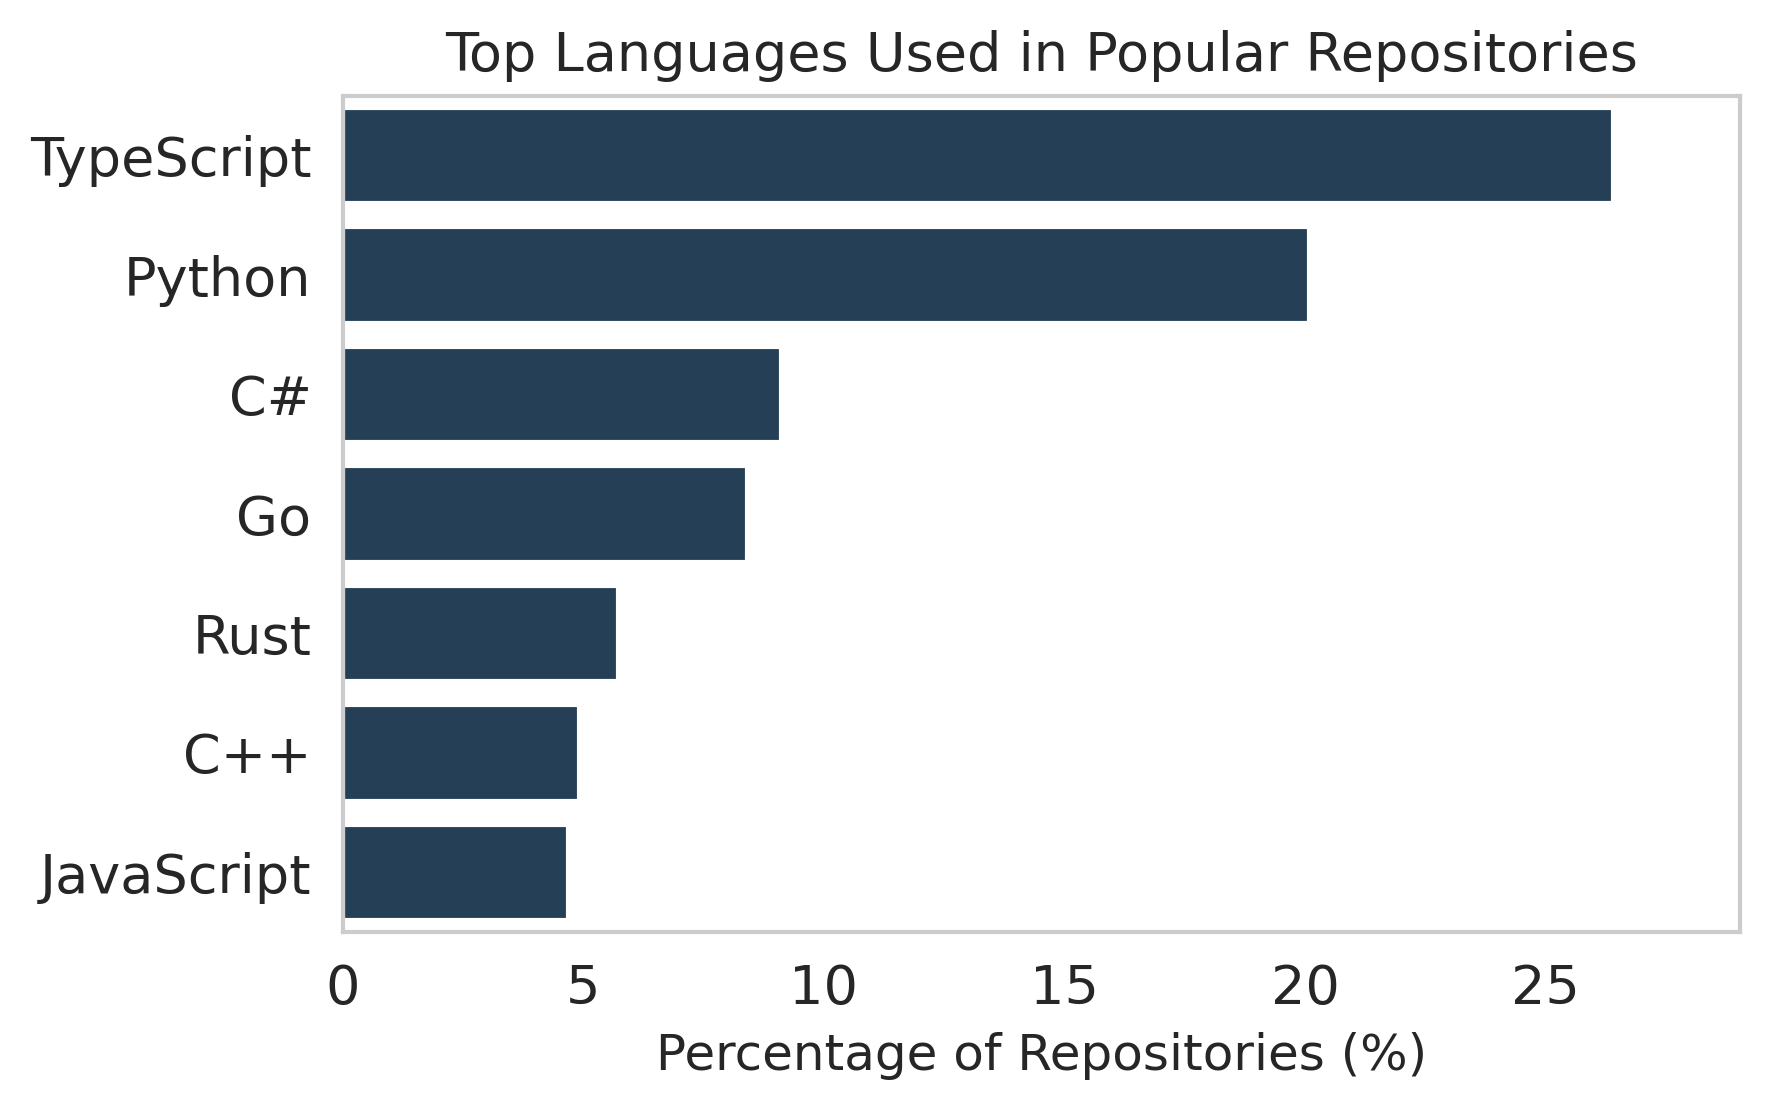

Wrote /home/leo/Projects/replication_package/AI_Teammates_in_SE3/figs/total_language_percentages_top.png


In [13]:
plot_total_language_percentages(totals, top_n=7)